In [312]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

sns.set(style='darkgrid')

#import the dataset

df_drivers = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/driver_ids.csv')
df_rides = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/ride_timestamps.csv')
df_ride_ids = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/ride_ids.csv')
df_rev = pd.read_csv('C:/Users/akmishra/Desktop/Test/Data/Rates.csv')

#Data Understanding

"""" look for number of records, min,max values"""

merged_rides.describe()
#check for #N/A values

print(df_rides.columns)
print(len(df_rides) - df_rides.count())
print(len(df_ride_ids) - df_ride_ids.count())
print(len(df_drivers) - df_drivers.count())

# drop the #N/As as there is only 1 #N/A in the whole dataset (col timestamp) so we can safely drop it.
df_rides = df_rides.dropna()
df_rev = df_rev.dropna()



#Prepare Data

"""" We prepare the data for our analysis by picking relevant columns and merging the datasets into one"""

#sort the ride info by ride id.
df_rides = df_rides.sort_values('ride_id')


# flatten the data for easier manipulation
pivoted = df_rides.pivot(index='ride_id', columns='event', values='timestamp').reset_index()

pivoted = pivoted.sort_values('ride_id')

#reformat the time stamp to extract the dates/hours/mins.
pivoted['accepted_at'] = pd.to_datetime(pivoted['accepted_at'])
pivoted['arrived_at'] = pd.to_datetime(pivoted['arrived_at'])
pivoted['dropped_off_at'] = pd.to_datetime(pivoted['dropped_off_at'])
pivoted['picked_up_at'] = pd.to_datetime(pivoted['picked_up_at'])
pivoted['requested_at'] = pd.to_datetime(pivoted['requested_at'])
pivoted['requested_at_hour'] = pivoted['requested_at'].dt.hour
pivoted['accepted_at_hour'] = pd.to_datetime(pivoted['accepted_at']).dt.hour
pivoted['accepted_at_day'] = pd.to_datetime(pivoted['accepted_at']).dt.weekday
pivoted['requested_at_day'] = pivoted['requested_at'].dt.weekday
pivoted['accepted_at_month'] = pd.to_datetime(pivoted['accepted_at']).dt.month


# find weekdays/weekends
pivoted['weekend'] = [1 if x >=5 else 0 for x in pivoted['requested_at_day'] ]

pivoted['accepted_date'] = pivoted['accepted_at'].dt.date 



df_rides = df_rides.sort_values('ride_id')

# find time to pickup
pivoted['time_to_pickup'] =  (pivoted['arrived_at'] - pivoted['accepted_at'])

pivoted['time_to_pickup'] = round(pivoted['time_to_pickup']/np.timedelta64(1, 's')/60,2)


#merge the dataset into 1 for easier access.
merged_rides = pivoted.merge(df_ride_ids, on = 'ride_id')


merged_rides['ride_distance'] = round(merged_rides['ride_distance']*0.00062137,2)
merged_rides['ride_duration'] = round(merged_rides['ride_duration']/60,2)
merged_rides['ride_prime_time'] = round(merged_rides['ride_prime_time']/60,2)


merged_rides['prime_perc'] = round(merged_rides['ride_prime_time']/merged_rides['ride_duration'],2)*100

#calculate fares.
merged_rides['fare'] = 2+ 1.15 * merged_rides['ride_distance'] + 0.22*merged_rides['ride_duration']+1.75

merged_rides = merged_rides.dropna()

merged_rides = merged_rides.sort_values(by=['driver_id', 'accepted_date'],ascending=[True,True])





Index(['ride_id', 'event', 'timestamp'], dtype='object')
ride_id      0
event        0
timestamp    1
dtype: int64
driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64
driver_id              0
driver_onboard_date    0
dtype: int64


In [313]:
# remove ride id as it's not useful for our analysis.
merged_rides = merged_rides.drop(['ride_id'], axis=1)

# implement lag functionality to get the next ride date in front of current ride date.
merged_rides['next_ride_date'] = merged_rides.groupby(['driver_id'])['accepted_date'].shift(-1)


In [314]:
#calculate number of days between current ride date and next ride date.
merged_rides['diff'] = merged_rides['next_ride_date'] - merged_rides['accepted_date']

merged_rides['diff'] = merged_rides['diff']/np.timedelta64(1, 'D')

#define churn for 30 days.
merged_rides['churned'] = [1 if x >=30  else 0 for x in merged_rides['diff']]


#dataset of churned drivers.
merged_rides_churned = merged_rides[merged_rides['churned'] == 1]


# last date on which a driver accepts a ride.
df_grouped = merged_rides.groupby(['driver_id'], sort=False)['accepted_at'].max()


merged_rides = merged_rides.merge(df_grouped, on = 'driver_id')

merged_rides['accepted_at_last'] = pd.to_datetime(merged_rides['accepted_at_y'])
merged_rides['accepted_at_last_date'] = merged_rides['accepted_at_last'].dt.date 



In [315]:
merged_rides = merged_rides.dropna()

#to account for drivers who quit more than a month before the last date in the dataset.
merged_rides['last_ride_diff'] = merged_rides['next_ride_date'].max() - merged_rides['accepted_at_last_date']




In [316]:

#define churn
merged_rides['churned'] = [1 if x >=pd.Timedelta(30,'D')  else 0 for x in merged_rides['last_ride_diff']]


In [317]:

churned_drivers = merged_rides_churned['driver_id'].unique()

df_churned = merged_rides.loc[merged_rides['driver_id'].isin(churned_drivers)]
df_churned['churned'] = 1

for x in churned_drivers :
    merged_rides.drop(merged_rides[merged_rides['driver_id'] == x].index,inplace=True)

#concatenate two datasets one churned other non churned.
df_total = pd.concat([merged_rides, df_churned], axis=0)


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


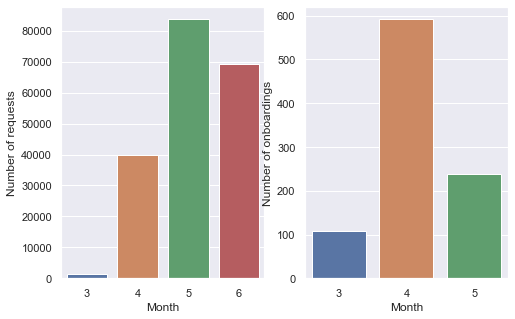

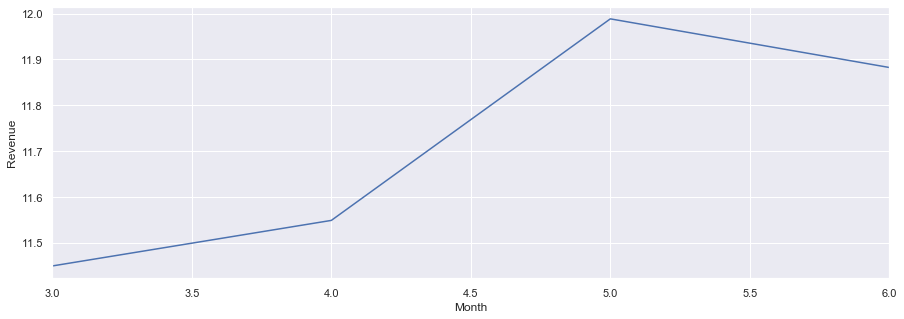

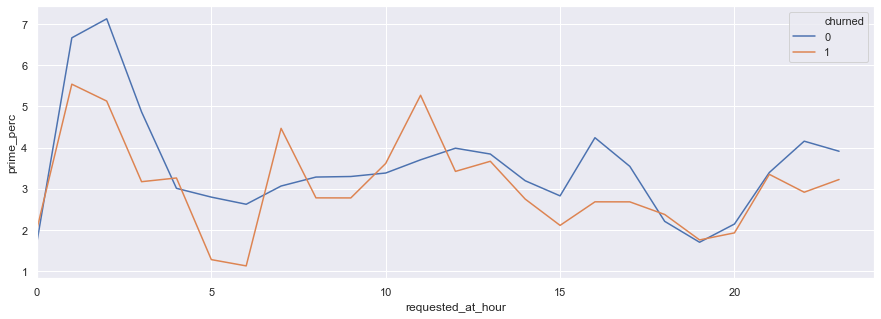

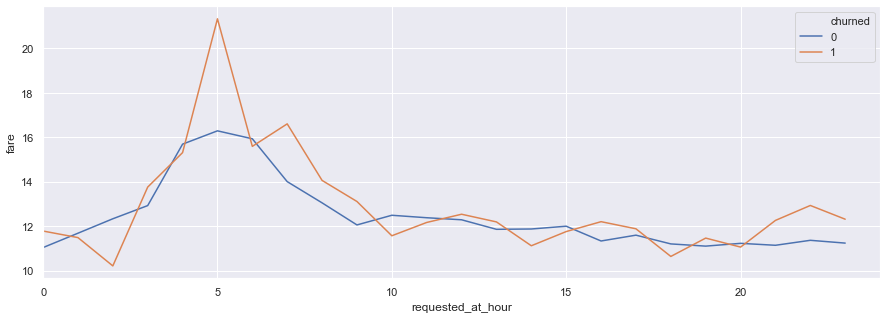

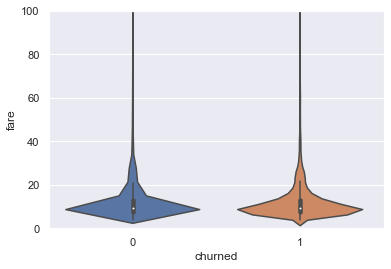

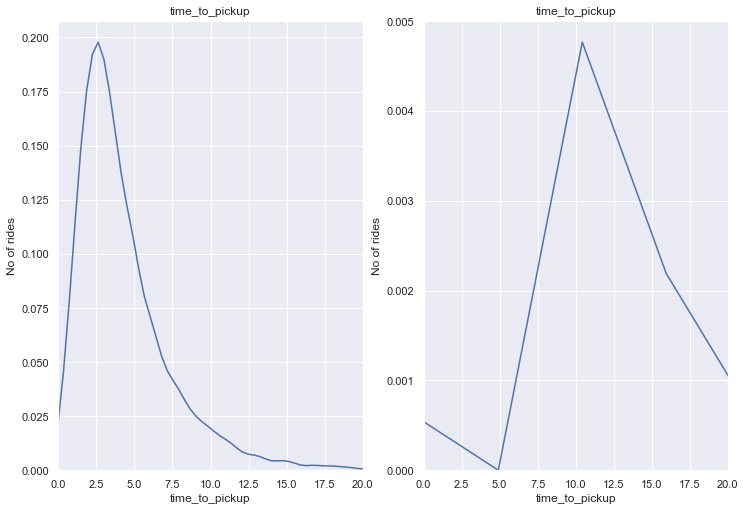

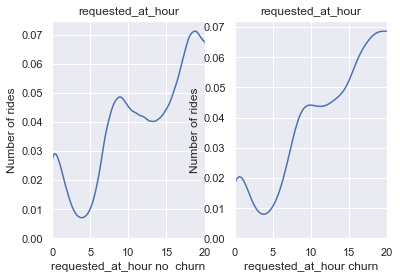

In [318]:
df_total = df_total.dropna()



#Business Understanding

""""Below we try to get a sense of the business as a whole, looking at the bigger picture"""

df_ride_dist = df_total[df_total['ride_distance'] !=0]
df_ride_dist['fare_per_mile'] = df_ride_dist['fare']/df_ride_dist['ride_distance']



fig2, axs2 = plt.subplots(ncols=2)
df_rides['timestamp'] = pd.to_datetime(df_rides['timestamp'])
df_rides['month'] = df_rides['timestamp'].dt.month

df_requests = df_rides[df_rides['event'] == "requested_at"]

sns.countplot(x='month',data=df_requests,ax=axs2[0])
axs2[0].set(xlabel='Month', ylabel='Number of requests')


df_drivers['driver_onboard_date'] = pd.to_datetime(df_drivers['driver_onboard_date'])
df_drivers['driver_onboard_month'] = df_drivers['driver_onboard_date'].dt.month


sns.countplot(x='driver_onboard_month',data=df_drivers,ax=axs2[1])
axs2[1].set(xlabel='Month', ylabel='Number of onboardings')

fig2.set_size_inches(8,5)



df_rides['timestamp'] = pd.to_datetime(df_rides['timestamp'])
df_rides['month'] = df_rides['timestamp'].dt.month




#see what the distribution of revenue looks like month to month
fig_fare_month, ax_fare_month = plt.subplots(ncols=1)
print_line_plot(df_total,ax_fare_month,'accepted_at_month','fare','',3,6,fig_fare_month,"Fare vs month",15,5)
ax_fare_month.set(xlabel='Month', ylabel='Revenue')



#Diving deeper

""""Below we try to get dive deep into how the data looks like in detail"""

#Data Modeling
"""" We try to plot different graphs in order to answer our questions"""

#see how the surcharge % varies by hour of the day
fig, ax = plt.subplots(ncols=1)

print_line_plot(df_total[df_total['weekend']==1],ax,'requested_at_hour','prime_perc','churned',0,24,fig,"Surcharge % vs hour of day",15,5)

#see how the fare varies by hour of the day
fig_fare, ax_fare = plt.subplots(ncols=1)
print_line_plot(df_total[df_total['weekend']==1],ax_fare,'requested_at_hour','fare','churned',0,24,fig_fare,"Fare vs hour of day",15,5)



fig1, ax_line = plt.subplots(ncols=1)
sns.violinplot( ax = ax_line, y = df_total["fare"],x=df_total['churned'] )   
ax_line.set_ylim(0,100)



fig2, axs2 = plt.subplots(ncols=2)

print_plot(df_ride_dist[df_ride_dist['churned']==1],axs2[0],"time_to_pickup","time_to_pickup",'No of rides',0,20,fig2,'time_to_pickup',12,8.27)
print_plot(df_ride_dist[df_ride_dist['churned']==0],axs2[1],"time_to_pickup","time_to_pickup",'No of rides',0,20,fig2,'time_to_pickup',12,8.27)



fig2.set_size_inches(12, 8.27)
fig4,axs4 = plt.subplots(ncols=2)


print_plot(df_ride_dist[df_ride_dist['churned']==0],axs4[0],"requested_at_hour","requested_at_hour no  churn",'Number of rides',0,20,fig2,'requested_at_hour',12,8.27)


print_plot(df_ride_dist[df_ride_dist['churned']==1],axs4[1],"requested_at_hour","requested_at_hour churn",'Number of rides',0,20,fig2,'requested_at_hour',12,8.27)


[Text(0, 0.5, 'Total Revenue'), Text(0.5, 0, 'Month')]

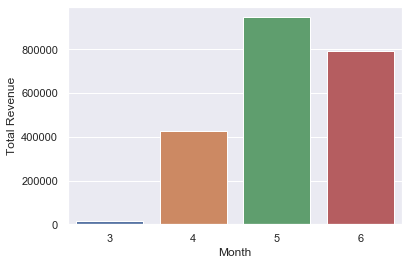

In [319]:

df_fare_by_month = df_total[['fare','accepted_at_month']]
df_fare_by_month=df_fare_by_month.groupby(['accepted_at_month'], as_index=False)['fare'].sum()


ax = sns.barplot(x="accepted_at_month", y="fare", data=df_fare_by_month)
ax.set(xlabel='Month', ylabel='Total Revenue')

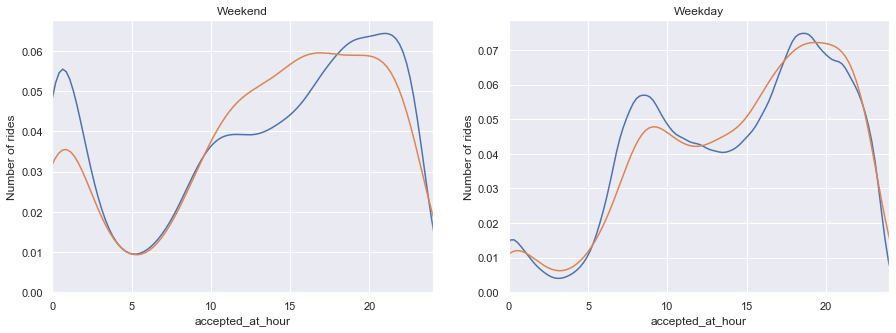

In [320]:
fig5,axs5 = plt.subplots(ncols=2)

print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)],axs5[0],"accepted_at_hour","accepted_at_hour",'Number of rides',0,24,fig5,"Weekend",15,5)
print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)],axs5[0],"accepted_at_hour","accepted_at_hour",'Number of rides',0,24,fig5,"Weekend",15,5)
print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)],axs5[1],"accepted_at_hour","accepted_at_hour",'Number of rides',0,24,fig5,"Weekday",15,5)
print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)],axs5[1],"accepted_at_hour","accepted_at_hour",'Number of rides',0,24,fig5,"Weekday",15,5)

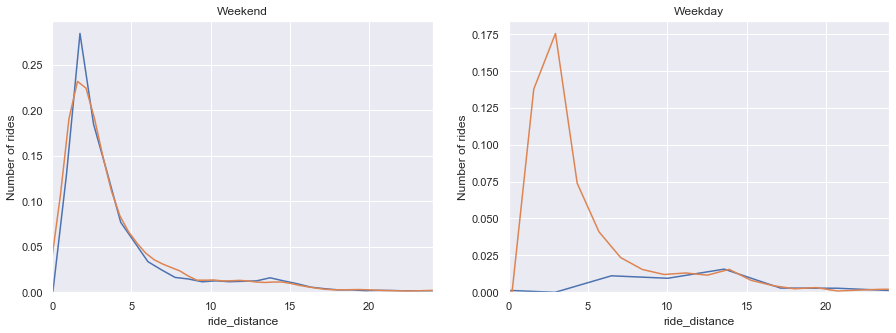

In [321]:

fig6,ax6=plt.subplots(ncols=2)

print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)],ax6[0],"ride_distance","ride_distance",'Number of rides',0,24,fig6,"Weekend",15,5)
print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)],ax6[0],"ride_distance","ride_distance",'Number of rides',0,24,fig6,"Weekend",15,5)


print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)],ax6[1],"ride_distance","ride_distance",'Number of rides',0,24,fig6,"Weekday",15,5)
print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)],ax6[1],"ride_distance","ride_distance",'Number of rides',0,24,fig6,"Weekday",15,5)



C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


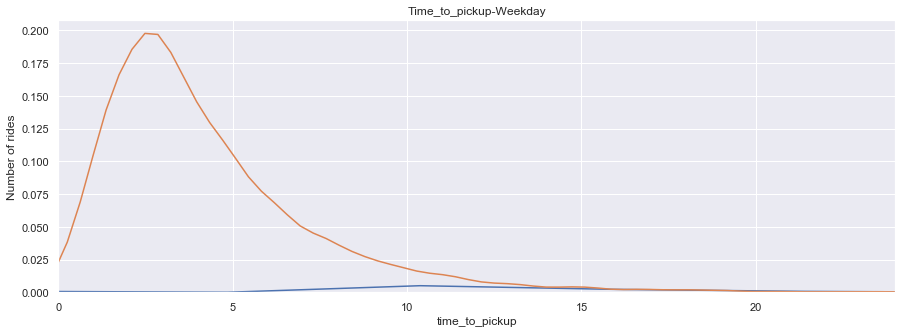

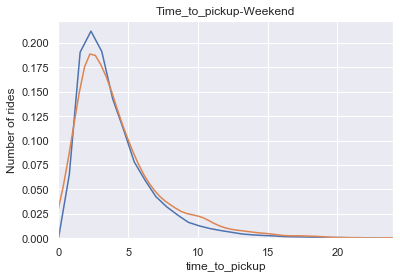

In [322]:
df_ride_dist['MA7_revenue']=df_ride_dist['fare'].rolling(window=7).mean()

fig6,ax6=plt.subplots(ncols=1)


print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)],ax6,"time_to_pickup","time_to_pickup",'Number of rides',0,24,fig6,"Time_to_pickup-Weekday",15,5)

print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)],ax6,"time_to_pickup","time_to_pickup",'Number of rides',0,24,fig6,"Time_to_pickup-Weekday",15,5)



fig_weekend,ax_weekend=plt.subplots(ncols=1)

print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)],ax_weekend,"time_to_pickup","time_to_pickup",'Number of rides',0,24,fig6,"Time_to_pickup-Weekend",15,5)

print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)],ax_weekend,"time_to_pickup","time_to_pickup",'Number of rides',0,24,fig6,"Time_to_pickup-Weekend",15,5)



[Text(0, 0.5, 'Surcharge %'), Text(0.5, 0, 'accepted_at_day')]

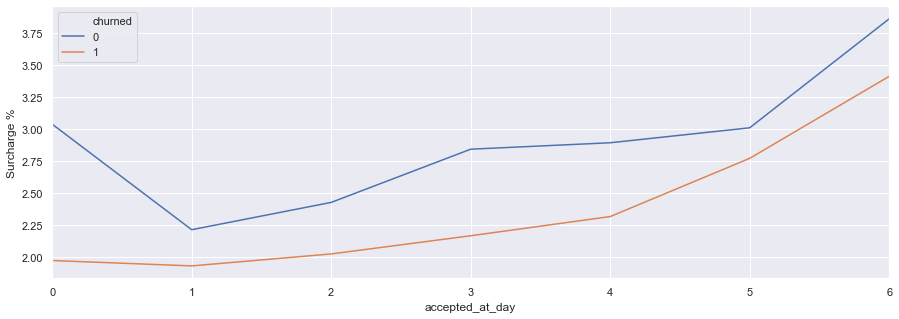

In [323]:
fig15,ax15=plt.subplots(ncols=1)

print_line_plot(df_ride_dist,ax15,'accepted_at_day','prime_perc','churned',0,6,fig15,"Surcharge %  vs Day of week",15,5)

ax15.set(xlabel='accepted_at_day', ylabel='Surcharge %')

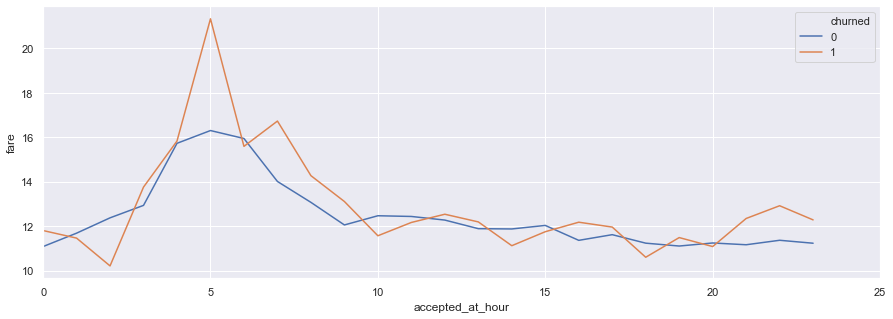

In [324]:
fig7,ax7=plt.subplots(ncols=1)
print_line_plot(df_ride_dist[df_ride_dist['weekend'] == 1],ax7,'accepted_at_hour','fare','churned',0,25,fig7,"Fare vs Accepted_at_hour",15,5)


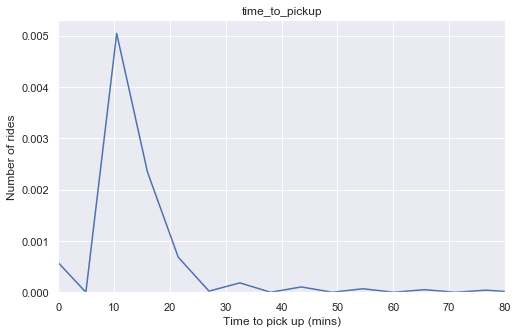

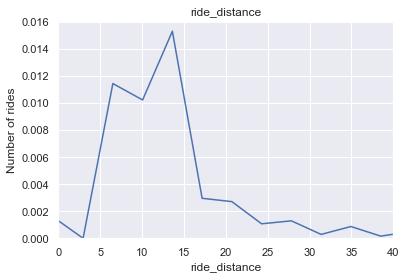

In [223]:
fig1, axs1 = plt.subplots(ncols=1)

print_plot(pivoted,axs1,"time_to_pickup","Time to pick up (mins)",'Number of rides',0,80,fig1,"time_to_pickup",8,5)

  

fig2, axs2 = plt.subplots(ncols=1)


print_plot(merged_rides,axs2,"ride_distance","ride_distance",'Number of rides',0,40,fig1,"ride_distance",8,5)


plt.show()

C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


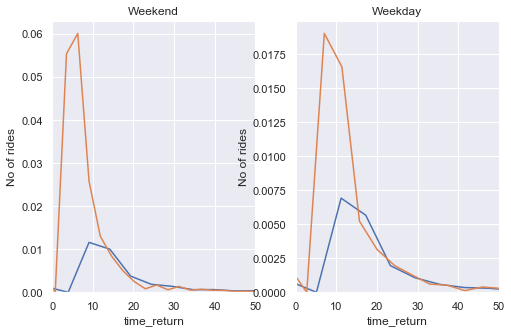

In [218]:
df_ride_dist['time_return'] = df_ride_dist['ride_duration']/df_ride_dist['time_to_pickup']
fig10,ax10 = plt.subplots(ncols=2)

print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 1)],ax10[0],"time_return","time_return",'No of rides',0,50,fig10,"Weekend",8,5)

print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 1)],ax10[0],"time_return","time_return",'No of rides',0,50,fig10,"Weekend",8,5)


print_plot(df_ride_dist[(df_ride_dist['churned']==0) & (df_ride_dist['weekend'] == 0)],ax10[1],"time_return","time_return",'No of rides',0,50,fig10,"Weekday",8,5)

print_plot(df_ride_dist[(df_ride_dist['churned']==1) & (df_ride_dist['weekend'] == 0)],ax10[1],"time_return","time_return",'No of rides',0,50,fig10,"Weekday",8,5)

ax10[1].set_xlim(0,50)
fig10.set_size_inches(8,5)


C:\Users\akmishra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


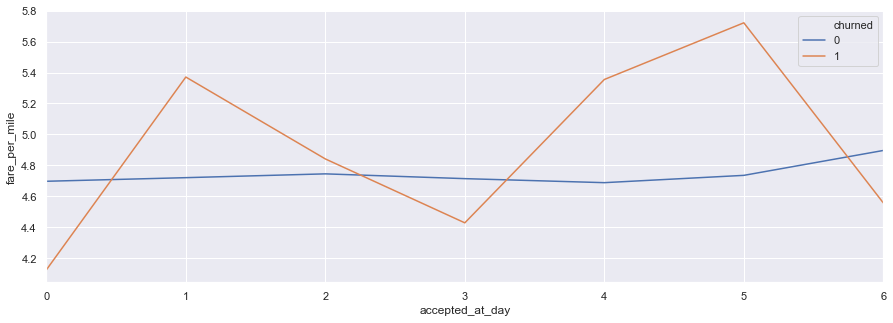

In [236]:
fig11,ax11 = plt.subplots(ncols=1)

df_ride_dist['EMA7_revenue'] = df_ride_dist['fare'].ewm(com=0.5).mean()

print_line_plot(df_ride_dist,ax11,'accepted_at_day','fare_per_mile','churned',0,6,fig11,"Fare_per_mile vs Day of week no churn",15,5)


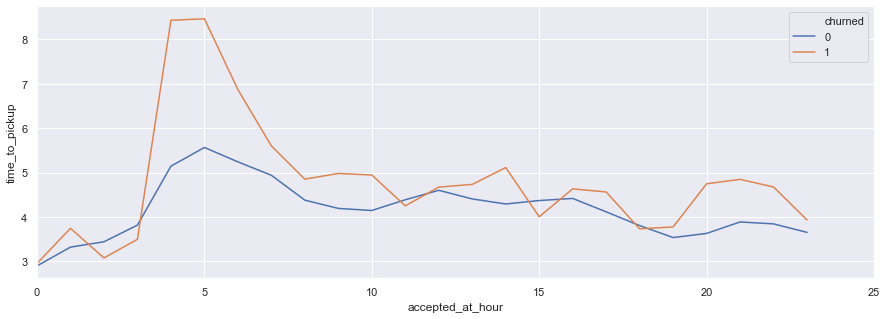

In [229]:
fig12,ax12 = plt.subplots(ncols=1)

print_line_plot(df_ride_dist[df_ride_dist['weekend'] == 1],ax12,'accepted_at_hour','time_to_pickup','churned',0,25,fig12,"Pick up time vs time of day",15,5)





In [168]:
df_ride_dist_corr = df_ride_dist[['accepted_at_hour','time_to_pickup', 'ride_distance', 'ride_duration',
'ride_prime_time', 'prime_perc', 'fare','churned','requested_at_day']]


In [169]:
print(df_ride_dist_corr.corr())

                  accepted_at_hour  time_to_pickup  ride_distance  \
accepted_at_hour          1.000000       -0.034240      -0.065988   
time_to_pickup           -0.034240        1.000000       0.184304   
ride_distance            -0.065988        0.184304       1.000000   
ride_duration            -0.030159        0.136163       0.789976   
ride_prime_time           0.004867        0.042175      -0.048641   
prime_perc                0.005665        0.019514      -0.099471   
fare                     -0.059502        0.179562       0.987453   
churned                   0.013909        0.017299       0.002684   
requested_at_day         -0.061072       -0.023253      -0.002434   

                  ride_duration  ride_prime_time  prime_perc      fare  \
accepted_at_hour      -0.030159         0.004867    0.005665 -0.059502   
time_to_pickup         0.136163         0.042175    0.019514  0.179562   
ride_distance          0.789976        -0.048641   -0.099471  0.987453   
ride_duration

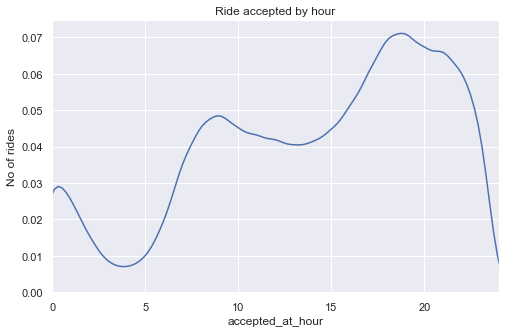

In [207]:
fig12,ax12 = plt.subplots(ncols=1)
print_plot(df_ride_dist,ax12,"accepted_at_hour","accepted_at_hour",'No of rides',0,24,fig12,"Ride accepted by hour",8,5)


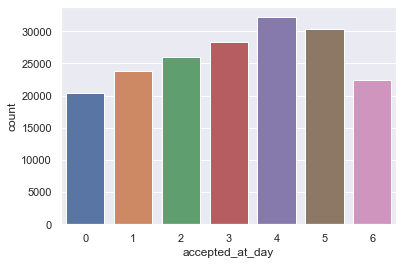

In [308]:
fig12_a,ax12_a = plt.subplots(ncols=1)

ax = sns.countplot(x="accepted_at_day", data=df_ride_dist)

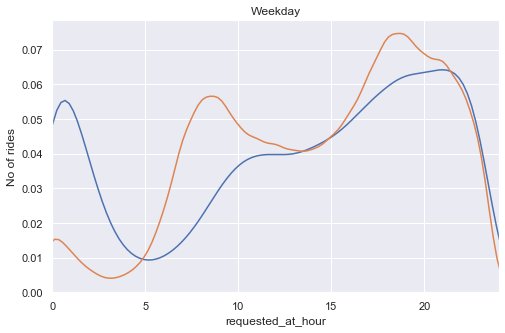

In [206]:
fig13,ax13 = plt.subplots(ncols=1)

print_plot(df_ride_dist[df_ride_dist['weekend'] == 1],ax13,"requested_at_hour","requested_at_hour",'No of rides',0,24,fig13,"Weekend",8,5)
print_plot(df_ride_dist[df_ride_dist['weekend'] == 0],ax13,"requested_at_hour","requested_at_hour",'No of rides',0,24,fig13,"Weekday",8,5)



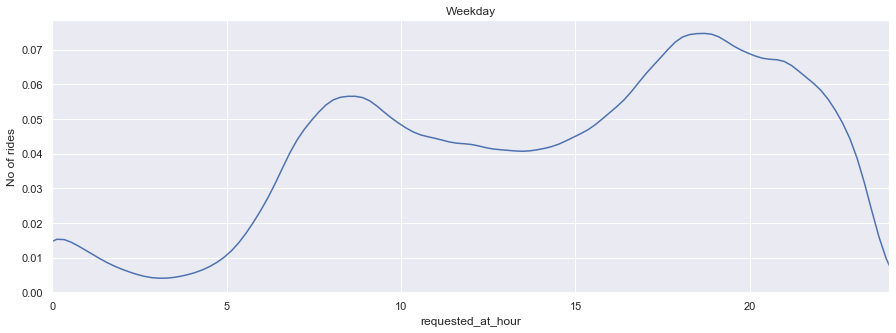

In [247]:

fig0,ax0=plt.subplots(ncols=1)
print_plot(df_ride_dist[df_ride_dist['weekend'] == 0],ax0,"requested_at_hour","requested_at_hour",'No of rides',0,24,fig0,'Weekday',15,5)

In [259]:

def print_plot(data,axes,parameter,x_label_data,y_label_data,x_lim_min,x_lim_max,fig,title,size_x,size_y):
    """Charts a distplot using the parameters received"""
    
    sns.distplot(data[parameter], hist=False,ax=axes).set_title(title);
    axes.set(xlabel=x_label_data, ylabel=y_label_data)
    axes.set_xlim(x_lim_min,x_lim_max)
    fig.set_size_inches(size_x,size_y)
    
    
    


def print_line_plot(data,axes,x_label_data,y_label_data,hue_data,x_lim_min,x_lim_max,fig,title,size_x,size_y):
    """Charts a line plot using the parameters received"""
    if hue_data=="":
        sns.lineplot(x=x_label_data,y=y_label_data,data=data,err_style =None)
    else:
        sns.lineplot(x=x_label_data,y=y_label_data,hue=hue_data, data=data,err_style =None)
    axes.set(xlabel=x_label_data, ylabel=y_label_data)
    axes.set_xlim(x_lim_min,x_lim_max)
    fig.set_size_inches(size_x,size_y)    
    
    
    